In [1]:
%reload_ext autoreload
%autoreload 2

# %matplotlib widget

%matplotlib qt

# %gui qt

import time
import random
from copy import copy
from tqdm import tqdm
from pathlib import Path
import numpy as np
import numba as nb
import scipy as sp
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.display.width = 1000

from vrAnalysis import session
from vrAnalysis import registration
from vrAnalysis import functions
from vrAnalysis import analysis
from vrAnalysis import helpers
from vrAnalysis import fileManagement as fm
from vrAnalysis import database
from vrAnalysis import tracking

from vrAnalysis.uiDatabase import addEntryGUI
from vrAnalysis.redgui import redCellGUI as rgui

sessiondb = database.vrDatabase('vrSessions')
mousedb = database.vrDatabase('vrMice')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update

# Further Requirements:
# ---------------------
# ROICaT Alignment Tools 
# Track Red Cell Consistency across days 
# Now that I've refactored the database code, need to update some things in documentation and probably elsewhere too


In [56]:
# Notes from meeting with Kenneth:

# - skewness (violin plot) of Control & Red -- 
#     - all - 
#     - just reliable -- for each session - 

# Subsample control data for scatter plot
# Fisher z transformation (but label by original correlation...)
# Question:
# -- if reliable on 1 day, is it reliable on other days? 
# -- make a matrix with source and target, color by fraction of reliable on target out of those reliable on source
# -- also do this with your session kernels for control and red
# -- also do this for different reliability cutoffs

In [10]:
track = tracking.tracker('ATL028') # get tracker object for mouse
pcm = analysis.placeCellMultiSession(track, autoload=False) # open up place cell multi session analysis object (don't autoload!!!)

In [13]:
for ses in track.sessions: print(ses.sessionPrint())


ATL028/2023-08-04/701
ATL028/2023-08-07/701
ATL028/2023-08-08/701


In [15]:
ises = sessiondb.iterSessions(mouseName='ATL028')

In [27]:
reg = registration.vrRegistration(ises[3])
reg.loadBehaviorStructure()

In [34]:
dir(reg.vrFile['trialInfo'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fieldnames',
 'activeLicking',
 'activeStopping',
 'frameIdx',
 'inRewardZone',
 'iti',
 'lick',
 'outcome',
 'pdLevel',
 'rewardAvailable',
 'rewardDeliveryFrame',
 'rewardPosition',
 'rewardTolerance',
 'roomPosition',
 'startPosition',
 'startTime',
 'stop',
 'time',
 'trialIdx',
 'userRewardFrames',
 'userRewardNumber',
 'vrEnvIdx']

In [18]:
for ses in ises:
    print(ses.sessionPrint())
    eidx = ses.loadone('trials.environmentIndex')
    print(np.unique(eidx))

ATL028/2023-08-01/701
[3]
ATL028/2023-08-02/701
[3]
ATL028/2023-08-03/701
[3]
ATL028/2023-08-04/701
[3]
ATL028/2023-08-07/701
[1 3]
ATL028/2023-08-08/701
[1 3]


In [11]:
pcm.plot_snake(3, cutoffs=(0.2, 0.5), withShow=True);

100%|██████████| 3/3 [00:45<00:00, 15.10s/it]


AssertionError: reward positions are not consistent: ([112.5, 162.5])

In [167]:
plt.close('all')
pcm.plot_rel_comparison(1, idx_ses=None, sortby=8)

In [175]:
idx_ses = pcm.idx_ses_with_env(3)
print(idx_ses)
sortby = [idx_ses[i] for i in [0, int(len(idx_ses)*0.5), -1]]
print(sortby)
        

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 13, 7]


In [29]:
num_ses = len(skew)

offset = 0.2
ctl_positions = np.linspace(0, num_ses-1, num_ses) - offset
red_positions = np.linspace(0, num_ses-1, num_ses) + offset

plt.close('all')
cvp = plt.violinplot([s[~ir] for s, ir in zip(skew, idx_red)], ctl_positions)
rvp = plt.violinplot([s[ir] for s, ir in zip(skew, idx_red)], red_positions)
# for pc in cvp['bodies']: pc.set_color('k')
# for pc in rvp['bodies']: pc.set_color('r')
plt.show()

In [77]:
x0 = np.random.normal(0,1,(10000,))
y0 = np.random.normal(0,1,(10000,)) + x0
x1 = np.random.normal(0,1,(10000,))-10
y1 = np.random.normal(0,1,(10000,)) - x1

all_x = np.concatenate((x0, x1))
all_y = np.concatenate((y0, y1))
extent = [all_x.min(), all_x.max(), all_y.min(), all_y.max()]
range = [[all_x.min(), all_x.max()], [all_y.min(), all_y.max()]]

num_bins = 25
H1, xe, ye = np.histogram2d(x1, y1, bins=num_bins, range=range)
H0, _, _ = np.histogram2d(x0, y0, bins=[xe,ye])
H_diff = H1.T - H0.T

extent = [xe.min(), xe.max(), ye.min(), ye.max()]
xc, yc = helpers.edge2center(xe), helpers.edge2center(ye)

# H_test = np.zeros((num_bins, num_bins))
# H_test[0,0]=1
# H_test[-1,0]=2
# H_test[0,-1]=3
# H_test[-1,-1]=4
# H_test = H_test.T
# print(H_test)

plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained', sharex=True, sharey=True)
sns.histplot(x=x0, y=y0, bins=[xe, ye], pthresh=0, cmap="Blues", ax=ax[0])
sns.histplot(x=x1, y=y1, bins=[xe, ye], pthresh=0, cmap="Blues", ax=ax[1])
plt.imshow(H_diff, interpolation=None, aspect='auto', origin='lower', extent=extent, cmap=sns.color_palette("icefire", as_cmap=True))
plt.show()

In [60]:
xe

array([-14.02193639, -10.48093206,  -6.93992772,  -3.39892338,
         0.14208095,   3.68308529])

In [61]:
ye

array([-5.93192747, -1.6668033 ,  2.59832087,  6.86344504, 11.12856921,
       15.39369338])

In [59]:
H0

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.137e+03, 4.405e+03, 1.000e+01, 0.000e+00, 0.000e+00],
       [4.800e+01, 4.031e+03, 3.680e+02, 0.000e+00, 0.000e+00]])

In [57]:
H1

array([[0.000e+00, 0.000e+00, 0.000e+00, 7.670e+02, 1.526e+03],
       [0.000e+00, 0.000e+00, 1.280e+02, 6.326e+03, 1.237e+03],
       [0.000e+00, 0.000e+00, 5.000e+00, 1.100e+01, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [9]:
# add methods to analysis documentation for pcm!!! (include explanation of idx_ses handling)

In [1]:
# Now just need the skew plots and the reliability plots relative to other sessions

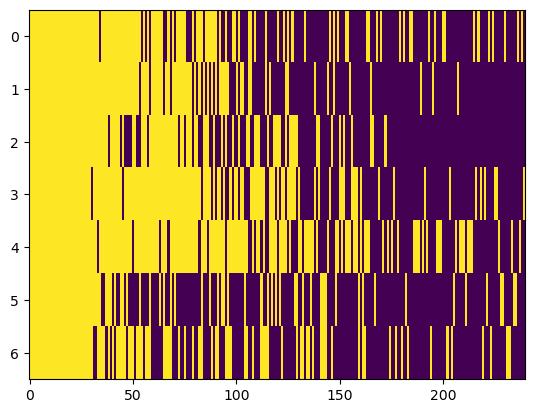

In [389]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None, use_s2p=True)
idx_has_red = idx_red[:, np.any(idx_red, axis=0)]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()

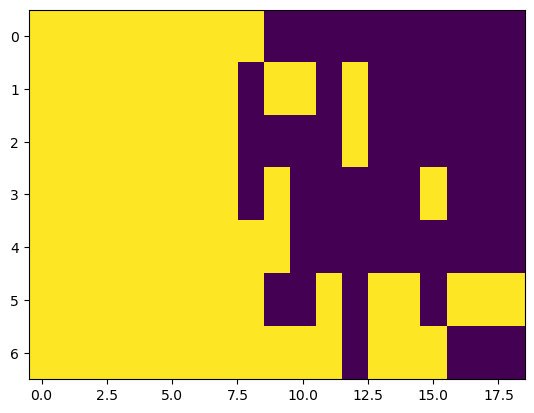

In [392]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None)
idx_has_red = idx_red[:, np.sum(idx_red, axis=0)>0]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()